In [1]:
class Value:
    def __init__(self,data,_childern=(),_op="",label = ""):
        self.data   = data
        self.grad   = 0.0
        self._prev  = set(_childern)
        self._op    = _op
        self.label  = label
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+",)
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        return out
    
        

In [2]:
a = Value(2.0,label="a")
b = Value(3.0,label="b")
c = Value(5.0,label="c")
e = a*b    ; e.label = "e"
d = e + c  ; d.label = "d"
f = Value(-2.0,label = "f")
L = d * f;L.label = "L" #output of the graph
d._prev # this means d is sum of a*b and c

{Value(data=5.0,grad=0.0), Value(data=6.0,grad=0.0)}

## Graphic representation

In [3]:
from graphviz import Digraph

In [4]:
def trace(root):
    nodes,edges = set(), set()
    def split(d):
        if d not in nodes:
            nodes.add(d)
            for child in d._prev:
                edges.add((child,d))
                split(child)
    split(root)
    return nodes,edges        

In [5]:
trace(d)

({Value(data=11.0,grad=0.0),
  Value(data=2.0,grad=0.0),
  Value(data=3.0,grad=0.0),
  Value(data=5.0,grad=0.0),
  Value(data=6.0,grad=0.0)},
 {(Value(data=2.0,grad=0.0), Value(data=6.0,grad=0.0)),
  (Value(data=3.0,grad=0.0), Value(data=6.0,grad=0.0)),
  (Value(data=5.0,grad=0.0), Value(data=11.0,grad=0.0)),
  (Value(data=6.0,grad=0.0), Value(data=11.0,grad=0.0))})

In [6]:
def trace(root):
    
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
        # if this value is a result of some operation, create an op node for it
        dot.node(name = uid + n._op, label = n._op)
        # and connect this node to it
        dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


import matplotlib.pyplot as plt
import networkx as nx

def draw_networkx(root):
    nodes, edges = trace(root)
    G            = nx.DiGraph()
    for n in nodes:
        G.add_node(n, label=f"{n.label}\ndata: {n.data}\ngrad: {n.grad}")

    for n1, n2 in edges:
        G.add_edge(n1, n2, label=n2._op)
        
    pos    = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True,
            labels=labels,
            node_size=3000,
            node_color='skyblue',
            font_size=10,
            font_weight='bold', arrowsize=20)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos,
                                 edge_labels=edge_labels,
                                 font_size=10)
    plt.title("Computational Graph")
    plt.show()

## Forward Propagation

- The below mathematical expression mimicing the forward propagation. d,e,f,L are functions and where L is final output.

In [7]:
a = Value(2.0,  label = "a")
b = Value(-3.0, label = "b")
c = Value(10.0, label = "c")
e = a * b ;  e.label = "e"
d = e + c ;  d.label = "d"
g = Value(-2.0,label = "g")
L = d * g;L.label = "L" #output of the graph
d._prev # this means d is sum of a*b and c

{Value(data=-6.0,grad=0.0), Value(data=10.0,grad=0.0)}

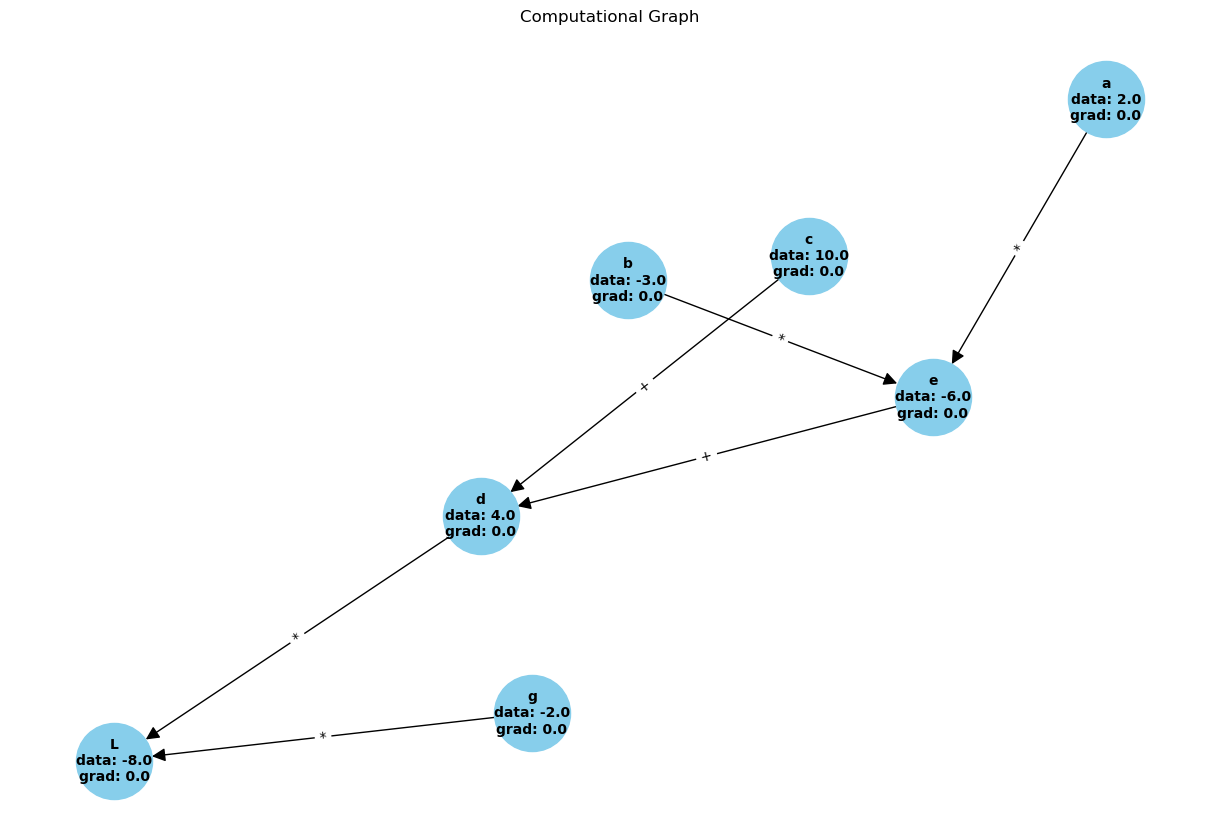

In [8]:
draw_networkx(L)

##  Backward propagation

 - Backward propagation, Calculate the gradient along the all the intermediate value of f,e,d,c,b,a
 - We calculate every single values ,ie, calculating  the gradient of L with respect to a,b,c,d,e,f. 
 
 _ How much change will occur in L when we cange a small value in a,b,c,d,e,f

In [9]:
class Value:
    def __init__(self,data,_childern=(),_op="",label = ""):
        self.data   = data
        self.grad   = 0.0
        self._prev  = set(_childern)
        self._op    = _op
        self.label  = label
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+",)
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        return out
    

In [10]:
## Lets find the gradient manually. 

def manually(with_respect_to=None):
    
    h = 0.001
    
    a = Value(2.0,label="a")
    b = Value(-3.0,label="b")
    c = Value(10.0,label="c")
    e = a*b    ; e.label = "e"
    d = e + c  ; d.label = "d"
    g = Value(-2.0,label = "g")
    L = d * g;   L.label = "L" 
    L1 = L.data
    
    a = Value(2.0, label="a")
    b = Value(-3.0,label="b")
    c = Value(10,  label="c")
    e = a*b    ; e.label = "e"
    d = e + c  ; d.label = "d"
    g = Value(-2.0,label = "g")
    L = d * g   ;L.label = "L"
    L2 = L.data + h
    
    gradient = ((L2-L1) / h)
    return f"Gradient = {gradient} with respect to {with_respect_to}"
manually(with_respect_to="a")
    

'Gradient = 1.000000000000334 with respect to a'

In [11]:
def manually(with_respect_to=None, h=0.001):
    # Original computation
    a = Value(2.0,  label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    e = a * b;    e.label = "e"
    d = e + c;    d.label = "d"
    g = Value(-2.0, label = "g")
    L = d * g;    L.label = "L"
    L1 = L.data
    
    
    # Perturb the variable by h using getattr and setattr
    variables = {'a': a, 'b': b, 'c': c, 'g': g}
    if with_respect_to in variables:
        var = variables[with_respect_to]
        setattr(var, 'data', getattr(var, 'data') + h)

    # Recompute after perturbation
    e = a * b;    e.label = "e"
    d = e + c;    d.label = "d"
    L = d * g;    L.label = "L"
    L2 = L.data

    # Calculate the gradient
    gradient = (L2 - L1) / h
    print(gradient)

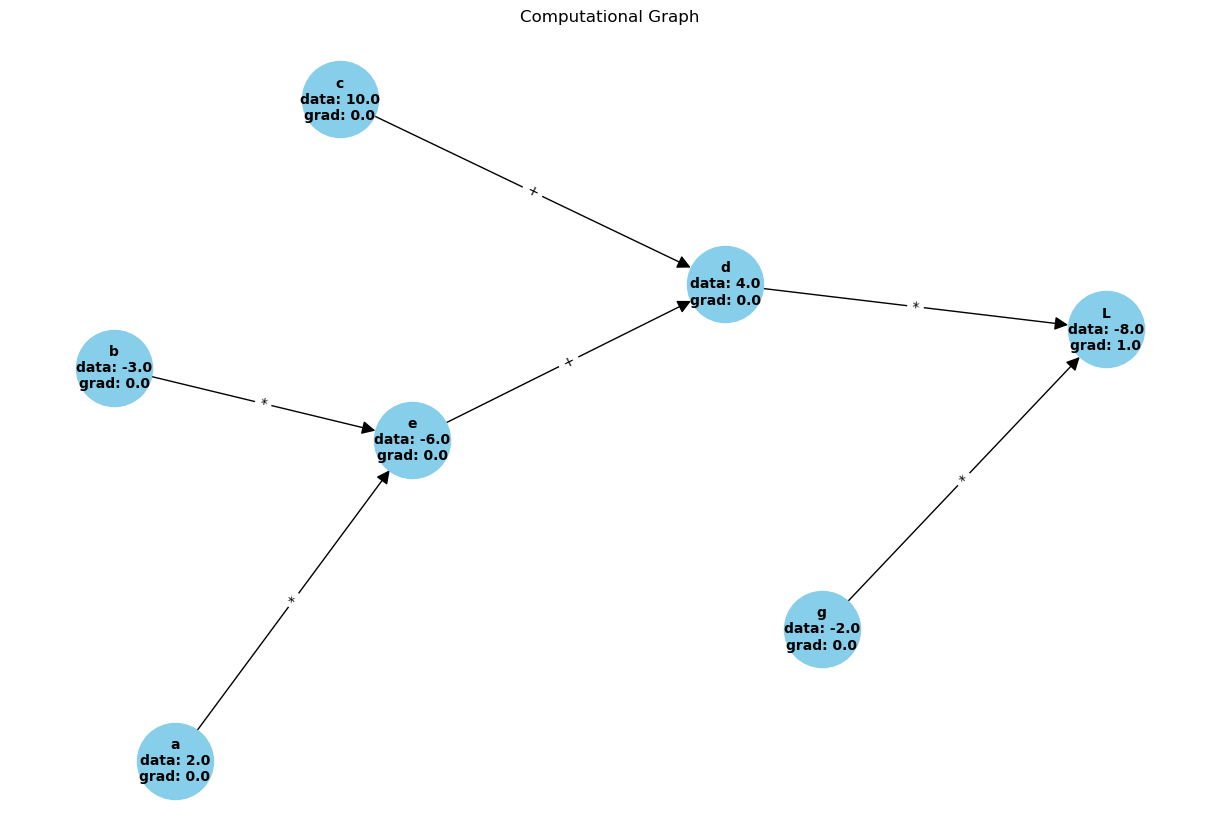

In [12]:
# when L changes h tiny, gradient is 
L.grad = 1.0
draw_networkx(L)

- L = d*g
- d = e + c

---------------------------------
Lets find the gradnet of L w.r.t d

- L = d*g          
     dL/dd = ??? ==> differentiate L with respect to d, The result is g.

        (f(x+h) - f(x)) / h 
        ((d+h)*g - (d*g)) / h
-  simplify it 
dL / dd = (d*g + h*g - d*g) / h  = g
- dL / dd = -2.0 

-----------------------------------
- Lets find the gradient of L w.r.t g

dL / dg = ??? ==>> differentiate L w.r.to g, the result is d
- dL / dg = 4.0


In [13]:
g.grad =  4.0
d.grad = -2.0


Lets find gradient of L w.r.t c. 

- dL / dc = ??? 
- dL / de = ??? 

In this condition c effecting d and then L, ie, when we change small change in "c" it effects the "d" and then it changes the value of "L".

- Before calculating 
    - dL / dc, lets find how much "c" effecting "d"
    - dL / de, lets find how much "e" effecting "d"

- d = e + c
- dd / dc = d(e+c) / dc
- dd / dc = 1.0 
--------------------------------------
- dd / de = d(e+c) / de
- dd / de = 1 



We can calculate the gradient of L with help of **chain rule**. 

- **chain rule** : If a variable L depends on the variable d, which itself depends on the variable c (that is, d and L are dependent variables), then L depends on c as well, via the intermediate variable d.

    1.  dL / dc = (dL/dd) * (dd/dc)
        - Here we know 
            - dL / dd = -2.0
            - dd / dc = 1.0 
            - dL / dc = -2.0 * 1.0 = -2.0
    2. dL / de = (dL / dd) * (dd / de)
        - Here we know 
            - dL / dd = -2.0 
            - dd / de = 1.0 
            - dL / de = -2.0 * 1.0 = -2.0 
    3. dL / da = (dL /dd) * (dd / de) * (de / da)
        - Here we know
            - dL / da = -2.0 * 3 = -6.0
    4. dL / db = (dL / dd) * (dd / de) * (de / db)
        - Here we know 
            - dL / db = -2.0 * 2.0 = 4.0


In [14]:
## lets check it 
manually("c") # we got the result as -2.0 

-1.9999999999988916


In [15]:
manually("a")

6.000000000000227


In [16]:
manually("b")

-3.9999999999995595


In [17]:
a.grad =  6.0
b.grad = -4.0
c.grad = -2.0
d.grad = -2.0 
e.grad = -2.0 
g.grad =  4.0
L.grad =  1.0

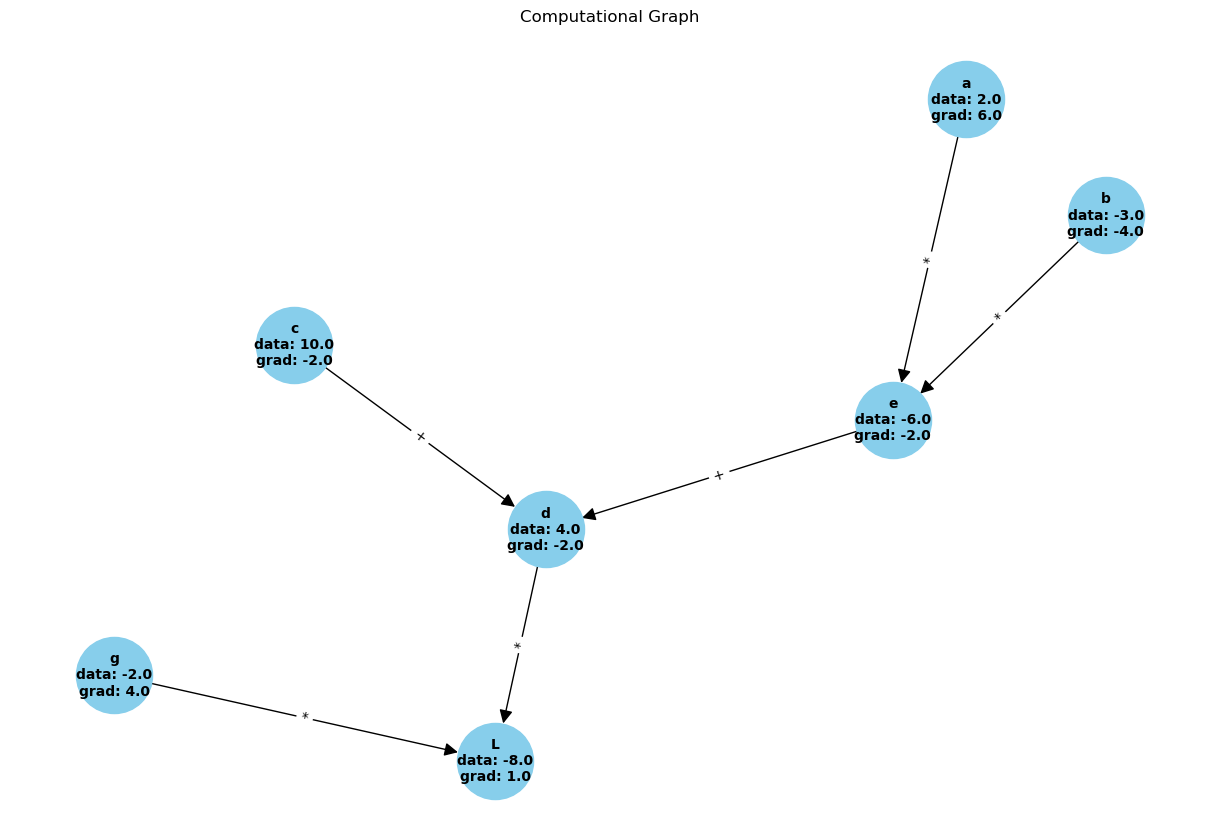

In [18]:
draw_networkx(L)

In [19]:
## Lets nudge the leaf nodes lil bit,Becasue leaf nodes has influencing more control over the L. 

a.data += 0.01 * a.grad 
c.data += 0.01 * c.grad 
c.data += 0.01 * c.grad 
g.data += 0.01 * g.grad 

e = a * b 
d = e + c 
L = d * g
print(L.data)


-7.408800000000002


## Backpropagate through Neurons

![](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

Consider x is input, w is weight, b is bias. the synapse in mathematic reprsentation is define as weights then inputs are interact with weights (w). 


1. **Input (x)**: Neurons receive input data, which can be raw data or the output of other neurons in the previous layer.

2. **Weights (w)**: Each input is associated with a weight, representing the strength or importance of that input.

3. **Weighted Sum**: The neuron calculates the weighted sum of its inputs by multiplying each input by its corresponding weight and then summing the results.
    - z=i∑​xi​wi​

4. **Bias (b)**: A bias term is added to the weighted sum to allow the activation function to be shifted. This helps the model fit the data better.
    - z=i∑​xi​wi​+b

5. **Activation Function (φ)**: The weighted sum with the bias is passed through an activation function to introduce non-linearity into the model. Common activation functions include sigmoid, ReLU, and tanh.
    - a=ϕ(z)

6. **Output (y)**: The result of the activation function is the output of the neuron, which can be fed as input to neurons in the next layer or used as the final output.

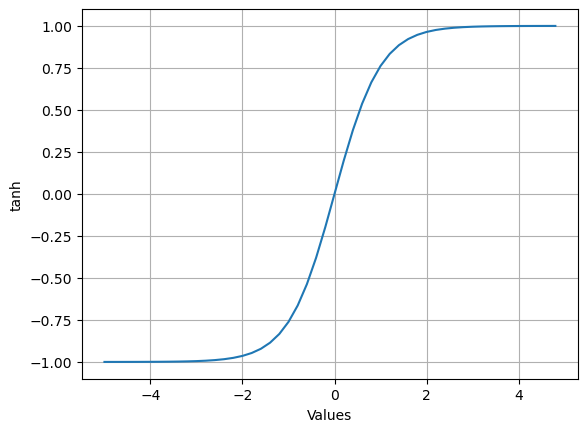

In [20]:
import math 
import numpy as np
import matplotlib.pyplot as plt


## In this case we use tanh function
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.xlabel("Values")
plt.ylabel("tanh")
plt.grid()

In [21]:
class Value:
    def __init__(self,data,_childern=(),_op="",label = ""):
        self.data   = data
        self.grad   = 0.0
        self._prev  = set(_childern)
        self._op    = _op
        self.label  = label
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+",)
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        return out
    def tanh(self):
        x   = self.data
        t   = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,(self,),_op="tanh")    
        return out

In the context of computational graphs and neural networks, the terms used to describe the various nodes help clarify the role and position of each element in the graph. 
- Given that 
    - x1, w1, x2, w2, b   ----- leaf nodes         ( Input values or weights that are not derived from any other nodes),
    - x1w1, x2w2,x1w1x2w2 ----- Intermediate nodes ( These nodes are result of some form of opeartions like sum, product, tanh)
    - o                   ----- Output node        ( This node derived from node "n" through an activation function) 
    

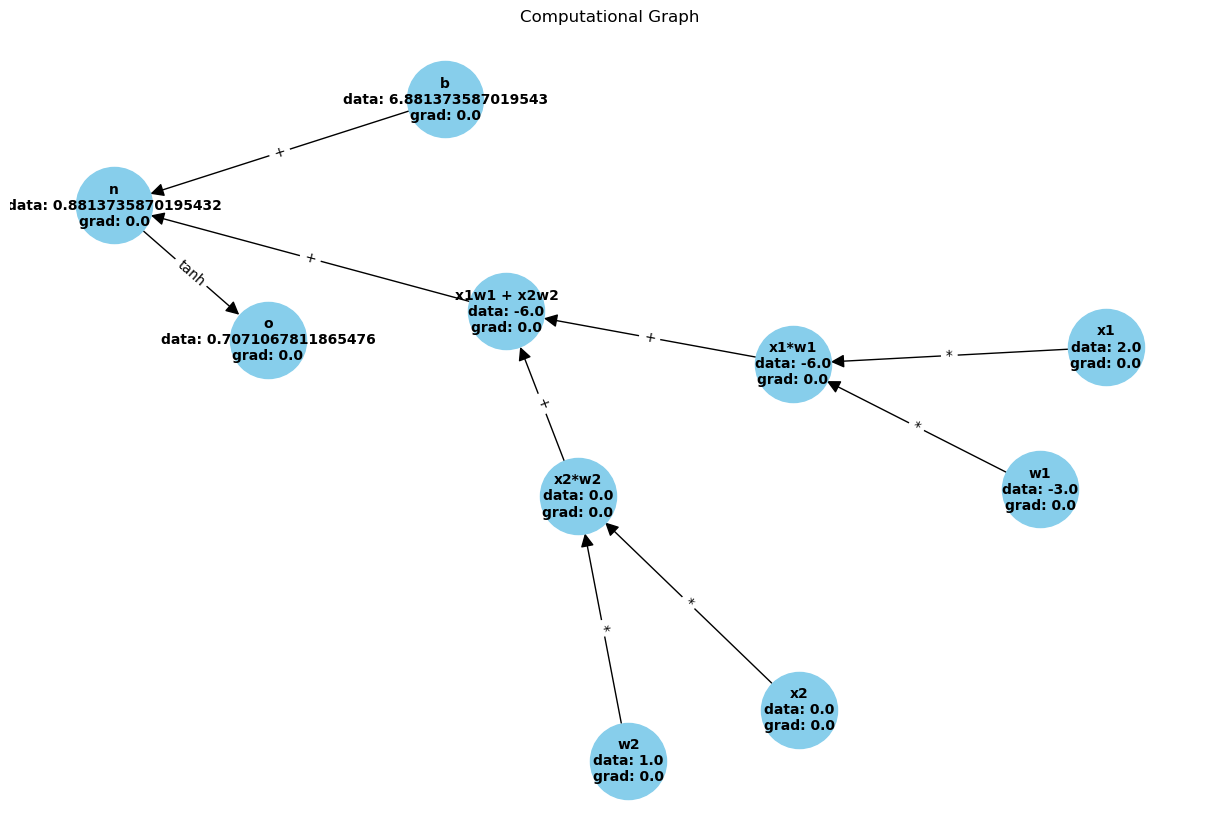

In [22]:
#inputs
x1 = Value(2.0,label = "x1")
x2 = Value(0.0,label = "x2")

#weights
w1 = Value(-3.0,label = "w1")
w2 = Value(1.0,label = "w2")

#bias
b  = Value(6.8813735870195432,label = "b") 

#dot product
x1w1     = x1 * w1;     x1w1.label = "x1*w1"
x2w2     = x2 * w2;     x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2" # sum of product of weights and input ()

# cell body 
n = x1w1x2w2 + b; n.label = "n"

# activation function
o = n.tanh(); o.label = "o"

# plot the output 
draw_networkx(o)

### Let's backpropagate manually

- do / do = 1
- do / dn = d (tanh(n)) / dn 
    - => 1 - tanh(n) **2 
    - => 1 - o**2 
    - => 1 - o.data ** 2
    - => 1 - 0.5 = 0.5

In [23]:
o.grad = 1.0
n.grad = 0.5

Lets find the gradient of x1*w1 + x2*w2 and b. 

- The sumation is the distributor of gradient. The gradient of "x1w1x2w2" and "b" would be equal to gradient of "n".
    - do / d(x1w1x2w2) = 0.5
    - do / d(b)        = 0.5 
- Same as above, gradient of x2*w2 and x1*w2 would be equalto gradient of previous node's gradient.
    - do / d(x1*w1) = 0.5
    - do / d(x2*w2) = 0.5 

In [24]:
x1w1x2w2.grad = 0.5
b.grad        = 0.5 

In [25]:
x1w1.grad = 0.5
x2w2.grad = 0.5 

In [26]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

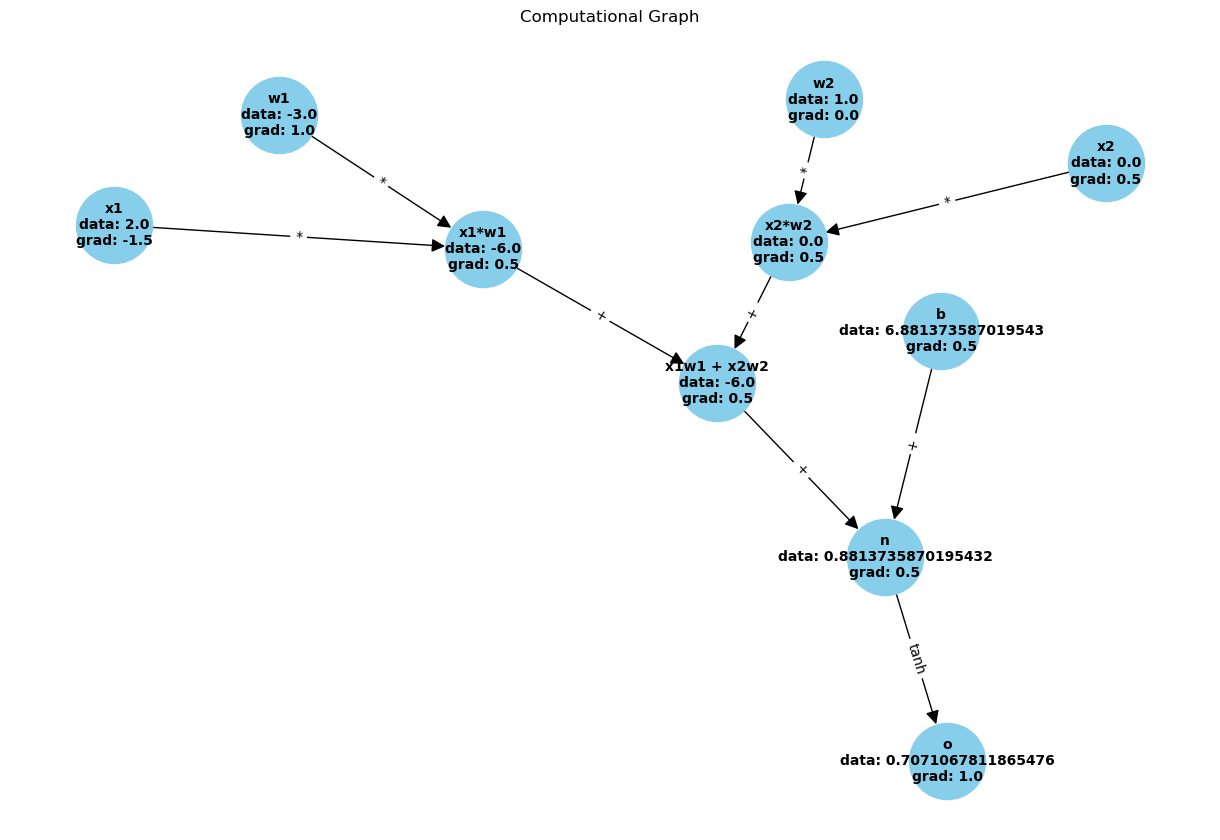

In [27]:
draw_networkx(o)

## Back propagation 

In [28]:
class Value:
    def __init__(self,data,_childern=(),_op="",label = ""):
        self.data      = data
        self.grad      = 0.0
        self.label     = label
        self._op       = _op
        self._backward = lambda:None # no effects on leaf nodes, 
        self._prev     = set(_childern)
        
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+",)
        def _backward():
            self.grad  = 1.0 * out.grad    # d(self + other) / d (self) = 1
            other.grad = 1.0 * out.grad    # d(self + other) / d (other) = 1
            
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad  = other.data * out.grad   # d(self * other) / d(self) = other
            other.grad = self.data * out.grad    # d(self * other) / d(self) = self
        out._backward = _backward
        return out
    
    def tanh(self):
        x   = self.data
        t   = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,(self,),_op="tanh")    
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        return out

In [29]:
#inputs
x1 = Value(2.0,label = "x1")
x2 = Value(0.0,label = "x2")

#weights
w1 = Value(-3.0,label = "w1")
w2 = Value(1.0,label = "w2")

#bias
b  = Value(6.8813735870195432,label = "b") 

#dot product
x1w1     = x1 * w1;     x1w1.label = "x1*w1"
x2w2     = x2 * w2;     x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2" # sum of product of weights and input ()

# cell body 
n = x1w1x2w2 + b; n.label = "n"

# activation function
o = n.tanh();     o.label = "o"

We laid out the mathematical expression and go backward through the expression. The backward propagation is done after all the operations have been completed. It means we start from the final output and work our way back through each layer, computing the gradients of the loss function with respect to each parameter in the network. This process is crucial for updating the weights in a way that minimizes the loss.

- This ordering of graph can be achieved using **Topological sort** 
- Topological: Its basically out of such that all the edges go only from **left


### Topological sort 

In [30]:
topological = []
visited = set()

def create_topological(output_node):
    if output_node not in visited:
        visited.add(output_node.label) 
        for child in output_node._prev:
            create_topological(child)
        topological.append(output_node)

create_topological(o) 

In [31]:
topological

[Value(data=0.0,grad=0.0),
 Value(data=1.0,grad=0.0),
 Value(data=0.0,grad=0.0),
 Value(data=-3.0,grad=0.0),
 Value(data=2.0,grad=0.0),
 Value(data=-6.0,grad=0.0),
 Value(data=-6.0,grad=0.0),
 Value(data=6.881373587019543,grad=0.0),
 Value(data=0.8813735870195432,grad=0.0),
 Value(data=0.7071067811865476,grad=0.0)]

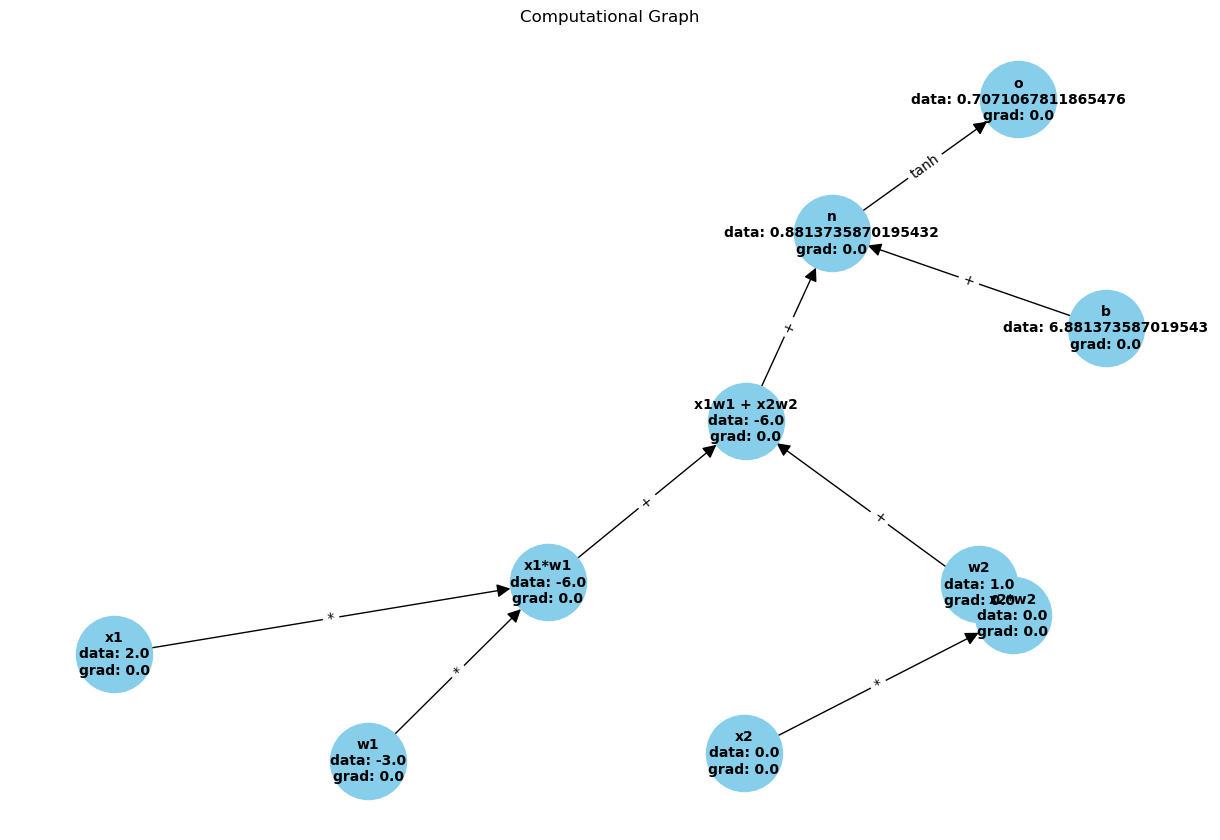

In [32]:
draw_networkx(o)

In [33]:
for i in reversed(topological):
    print(i.label,"====",i.data)

o ==== 0.7071067811865476
n ==== 0.8813735870195432
b ==== 6.881373587019543
x1w1 + x2w2 ==== -6.0
x1*w1 ==== -6.0
x1 ==== 2.0
w1 ==== -3.0
x2*w2 ==== 0.0
w2 ==== 1.0
x2 ==== 0.0


In [34]:
#lets do the backpropagation automatically, lets consider o.grad = 1, ie d(o) / d(o) = 1

o.grad = 1.0
topological = []
visited = set()

def create_topological(output_node):
    if output_node not in visited:
        visited.add(output_node.label) 
        for child in output_node._prev:
            create_topological(child)
        topological.append(output_node)

create_topological(o) 

for node in reversed(topological):
    node._backward()

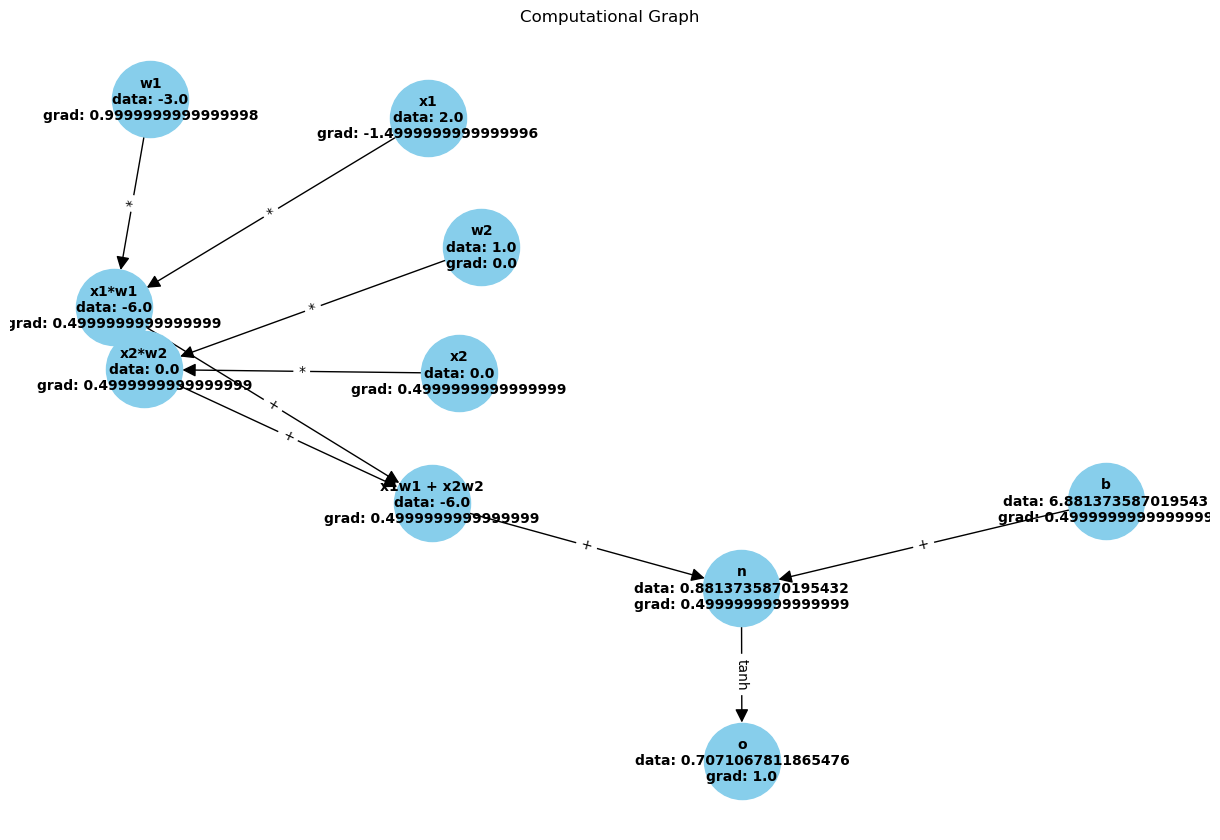

In [35]:
draw_networkx(o) ## the gradient of each nodes are changed. (find the gradient of each nodes.)

In [36]:
class Value:
    def __init__(self,data,_childern=(),_op="",label = ""):
        self.data      = data
        self.grad      = 0.0
        self.label     = label
        self._op       = _op
        self._backward = lambda:None # no effects on leaf nodes, 
        self._prev     = set(_childern)
        
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+",)
        def _backward():
            self.grad  = 1.0 * out.grad    # d(self + other) / d (self) = 1
            other.grad = 1.0 * out.grad    # d(self + other) / d (other) = 1
            
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad  = other.data * out.grad   # d(self * other) / d(self) = other
            other.grad = self.data * out.grad    # d(self * other) / d(self) = self
        out._backward = _backward
        return out
    
    def tanh(self):
        x   = self.data
        t   = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,(self,),_op="tanh")    
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
            
    def backward(self):
        topological = []
        visited = set()

        def create_topological(output_node):
            if output_node not in visited:
                visited.add(output_node) 
                for child in output_node._prev:
                    create_topological(child)
                topological.append(output_node)

        create_topological(self) 
        self.grad = 1.0
        for node in reversed(topological):
            node._backward()

In [37]:
#inputs
x1 = Value(2.0,label = "x1")
x2 = Value(0.0,label = "x2")

#weights
w1 = Value(-3.0,label = "w1")
w2 = Value(1.0,label = "w2")

#bias
b  = Value(6.8813735870195432,label = "b") 

#dot product
x1w1     = x1 * w1;     x1w1.label = "x1*w1"
x2w2     = x2 * w2;     x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2" # sum of product of weights and input ()

# cell body 
n = x1w1x2w2 + b; n.label = "n"

# activation function
o = n.tanh();     o.label = "o"

In [38]:
o.backward() 

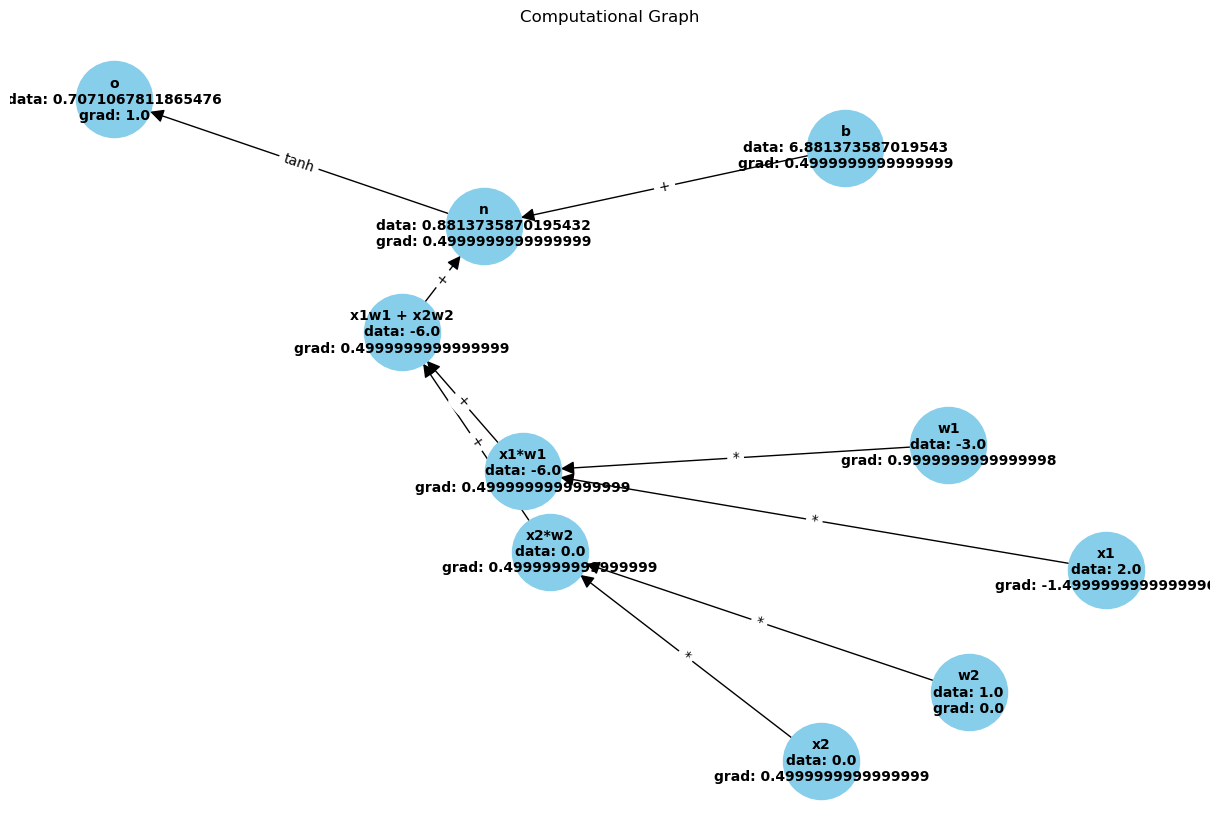

In [39]:
draw_networkx(o) 

## Bug Fixing 


### 1. Fixing backpropagation Bug when one node is used multiple times 

In [40]:
a = Value(11,label="a")
b = a + a ; b.label = "b" 
b.backward() 

In [41]:
print((a,a.label),(b,b.label))

(Value(data=11,grad=1.0), 'a') (Value(data=22,grad=1.0), 'b')


The gradient we got is wrong, ie, the gradient of 
- d(2a) / d(a) = 2

but we get 1, 


- This is because gradiet of each node is overwritten. we can fix by accumilating gradient of each node. 

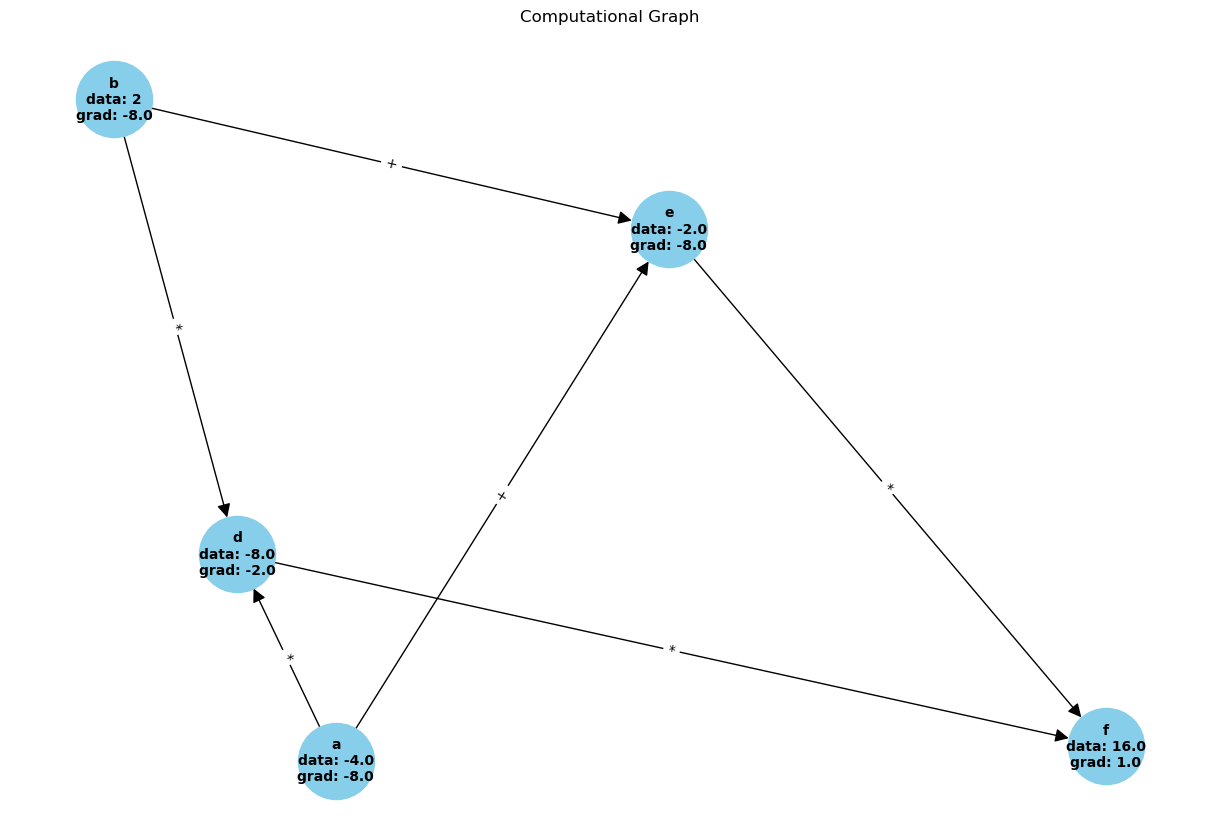

In [42]:
a = Value(-4.0,label="a")
b = Value(2,label="b") 

d = a * b; d.label = "d" 
e = a + b; e.label = "e" 
f = d * e; f.label = "f" 
f.backward() 
draw_networkx(f) 

In [43]:
class Value:
    def __init__(self,data,_childern=(),_op="",label = ""):
        self.data      = data
        self.grad      = 0.0
        self.label     = label
        self._op       = _op
        self._backward = lambda:None # no effects on leaf nodes, 
        self._prev     = set(_childern)
        
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+",)
        def _backward():
            self.grad  += 1.0 * out.grad    # d(self + other) / d (self) = 1
            other.grad += 1.0 * out.grad    # d(self + other) / d (other) = 1
            
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad  += other.data * out.grad   # d(self * other) / d(self) = other
            other.grad += self.data * out.grad    # d(self * other) / d(self) = self
        out._backward = _backward
        return out
    
    def tanh(self):
        x   = self.data
        t   = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,(self,),_op="tanh")    
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
            
    def backward(self):
        topological = []
        visited = set()

        def create_topological(output_node):
            if output_node not in visited:
                visited.add(output_node) 
                for child in output_node._prev:
                    create_topological(child)
                topological.append(output_node)

        create_topological(self) 
        self.grad = 1.0
        for node in reversed(topological):
            node._backward()

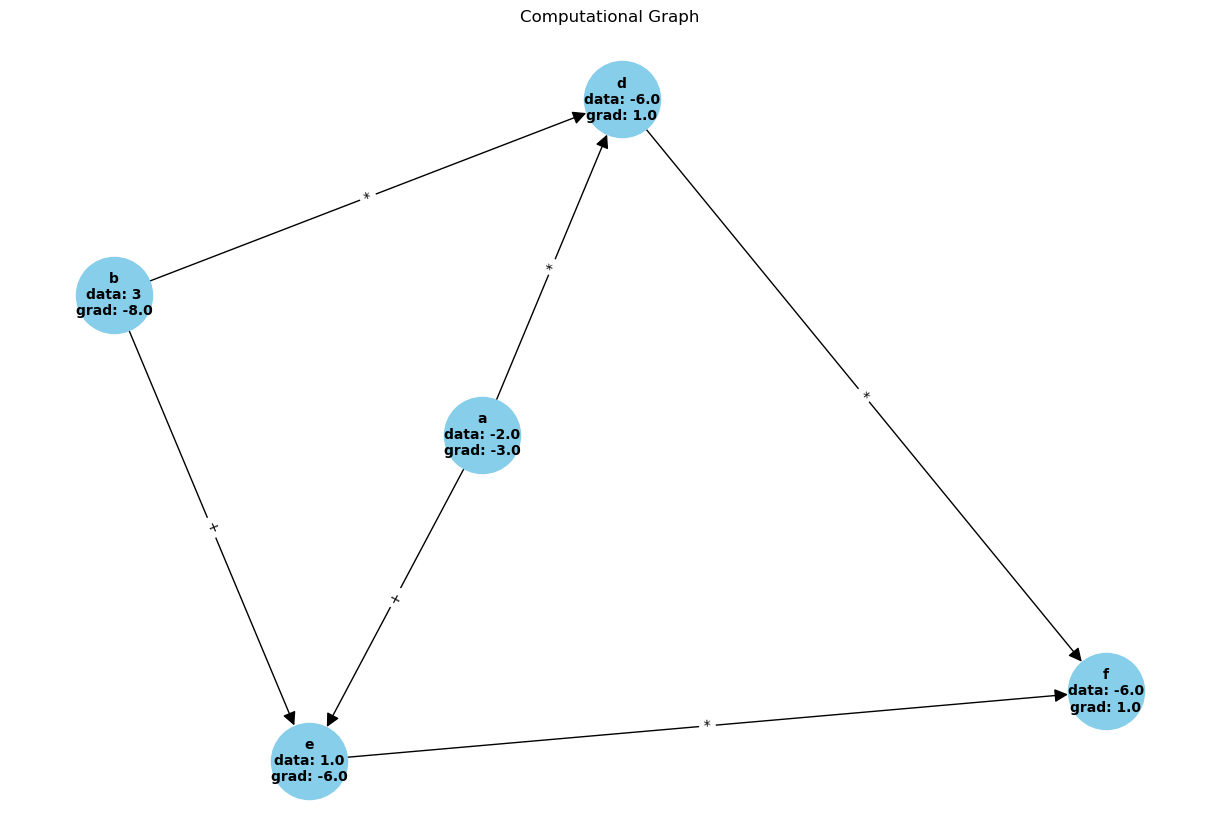

In [44]:
a = Value(-2.0,label="a")
b = Value(3,label="b") 

d = a * b; d.label = "d" 
e = a + b; e.label = "e" 
f = d * e; f.label = "f" 
f.backward() 
draw_networkx(f) 

### 2. Bug fixing more Operations

In [45]:
try:
    a = Value(-25) + 1  # Assuming Value obkect allows adding 1 with object
except AttributeError as a :
    print(a) 
    
    
# 1 is not a Value object, so Value(self.data + other.data,(self,other),"+",) is getting error.

'int' object has no attribute 'data'


![](https://d138zd1ktt9iqe.cloudfront.net/media/seo_landing_files/derivative-rules-1637316313.png)

In [46]:
class Value:
    def __init__(self,data,_childern=(),_op="",label = ""):
        self.data      = data
        self.grad      = 0.0
        self.label     = label
        self._op       = _op
        self._backward = lambda:None # no effects on leaf nodes, 
        self._prev     = set(_childern)
        
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other) 
        out   = Value(self.data + other.data,(self,other),"+",)
        def _backward():
            self.grad  += 1.0 * out.grad    # d(self + other) / d (self) = 1
            other.grad += 1.0 * out.grad    # d(self + other) / d (other) = 1
            
        out._backward = _backward
        return out
     
    def __radd__(self,other):                    # int * Value(),eg: 1* Value(2)
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out   = Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad  += other.data * out.grad   # d(self * other) / d(self) = other
            other.grad += self.data * out.grad    # d(self * other) / d(self) = self
        out._backward = _backward
        return out
    
    def __rmul__(self,other):                     # int * Value(), eg: 1* Value(2)
        return self * other  
    
    def __truediv__(self,other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1
        
    def __sub__(self,other):
        return self + (-other) 
    
    def __pow__(self,other):                                          # power opeartion
        assert isinstance(other,(int,float)),"Exponent must be an integer or float"
        out = Value(self.data**other, (self,), f'**{other}')          
        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad # power rule is given in the above,
        out._backward  = _backward
        return out 
    
    def exp(self): 
        x   = self.data
        out = Value(math.exp(x),(self,),label="exp") 
        def _backward():                             # differential of e^x is e^x
            self.grad += out.data * out.grad         
        out._backward = _backward
        return out 
    
    def tanh(self):
        x   = self.data
        t   = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,(self,),_op="tanh")    
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward  = _backward
        return out
            
    def backward(self):
        topological = []
        visited = set()
        def create_topological(output_node):
            if output_node not in visited:
                visited.add(output_node) 
                for child in output_node._prev:
                    create_topological(child)
                topological.append(output_node)
        create_topological(self) 
        
        self.grad = 1.0
        for node in reversed(topological):
            node._backward()

"""__rmul__"""
- method is used to handle multiplication when the left operand does not support the operation. 
    - int * Value() = TypeError: unsupported operand type(s) for *: 'int' and 'Value'
        We can fix this issue by defining __rmul__. 
        
        - int.__rmul__(Value()) 
    

In [47]:
a = Value(2.0) 
b = Value(10.0) 
a.__rmul__(12) # int * Value()

Value(data=24.0,grad=0.0)

In [48]:
a.__mul__(12)  # Value() * int

Value(data=24.0,grad=0.0)

In [49]:
(6).__pow__(2.3),(6).__pow__(2)

(NotImplemented, 36)

In [50]:
a.__pow__(2),a.__pow__(3.2),a.__pow__(2.2).label

(Value(data=4.0,grad=0.0), Value(data=9.18958683997628,grad=0.0), '')

In [51]:
a.__truediv__(12) 

Value(data=0.16666666666666666,grad=0.0)

In [52]:
a / b 

Value(data=0.2,grad=0.0)

In [53]:
b - a 

Value(data=8.0,grad=0.0)

In [54]:
a - b 

Value(data=-8.0,grad=0.0)

In [55]:
a ** 2  

Value(data=4.0,grad=0.0)

In [56]:
a ** b.data

Value(data=1024.0,grad=0.0)

In [57]:
-a * b 

Value(data=-20.0,grad=0.0)

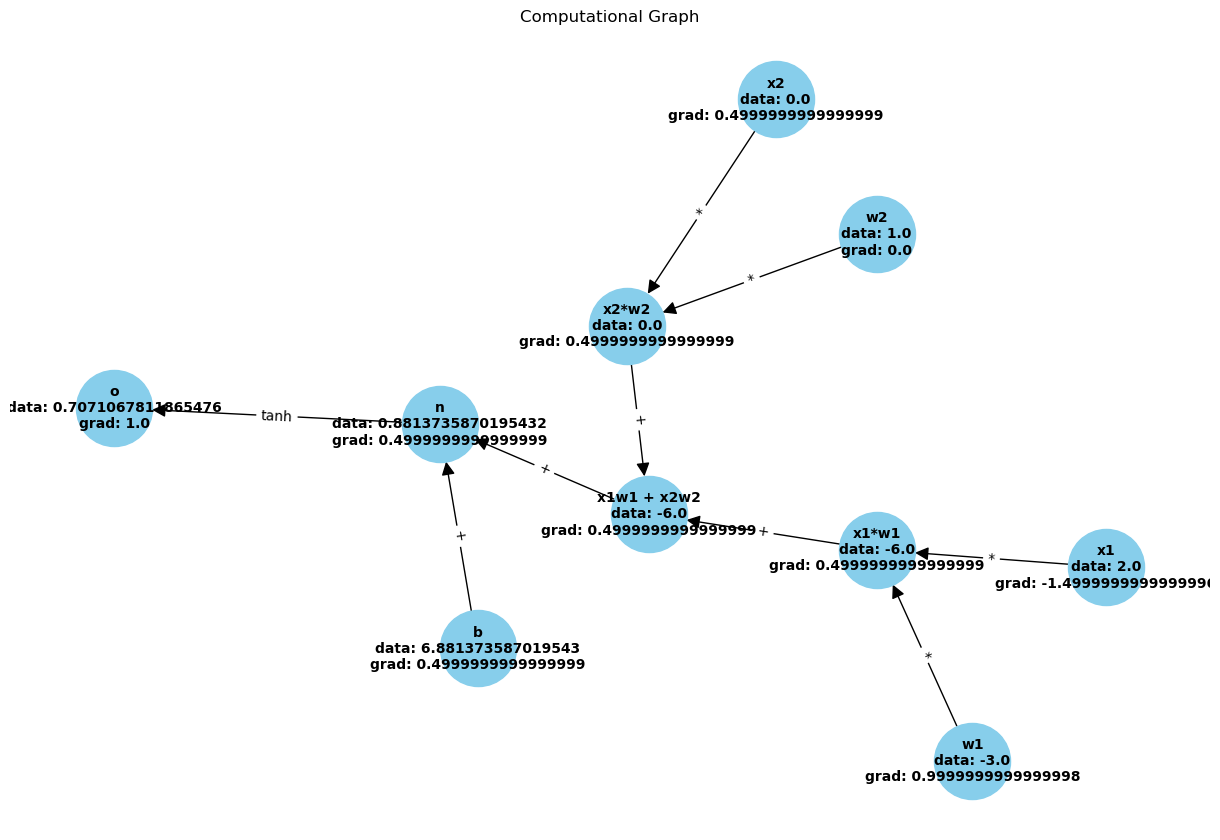

In [58]:
#inputs
x1 = Value(2.0,label = "x1")
x2 = Value(0.0,label = "x2")

#weights
w1 = Value(-3.0,label = "w1")
w2 = Value(1.0,label = "w2")

#bias
b  = Value(6.8813735870195432,label = "b") 

#dot product
x1w1     = x1 * w1;     x1w1.label = "x1*w1"
x2w2     = x2 * w2;     x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2" # sum of product of weights and input ()

# cell body 
n = x1w1x2w2 + b; n.label = "n"

# activation function
o = n.tanh();     o.label = "o"


o.backward()
draw_networkx(o) 

### Lets brakedown the **tanh()** 

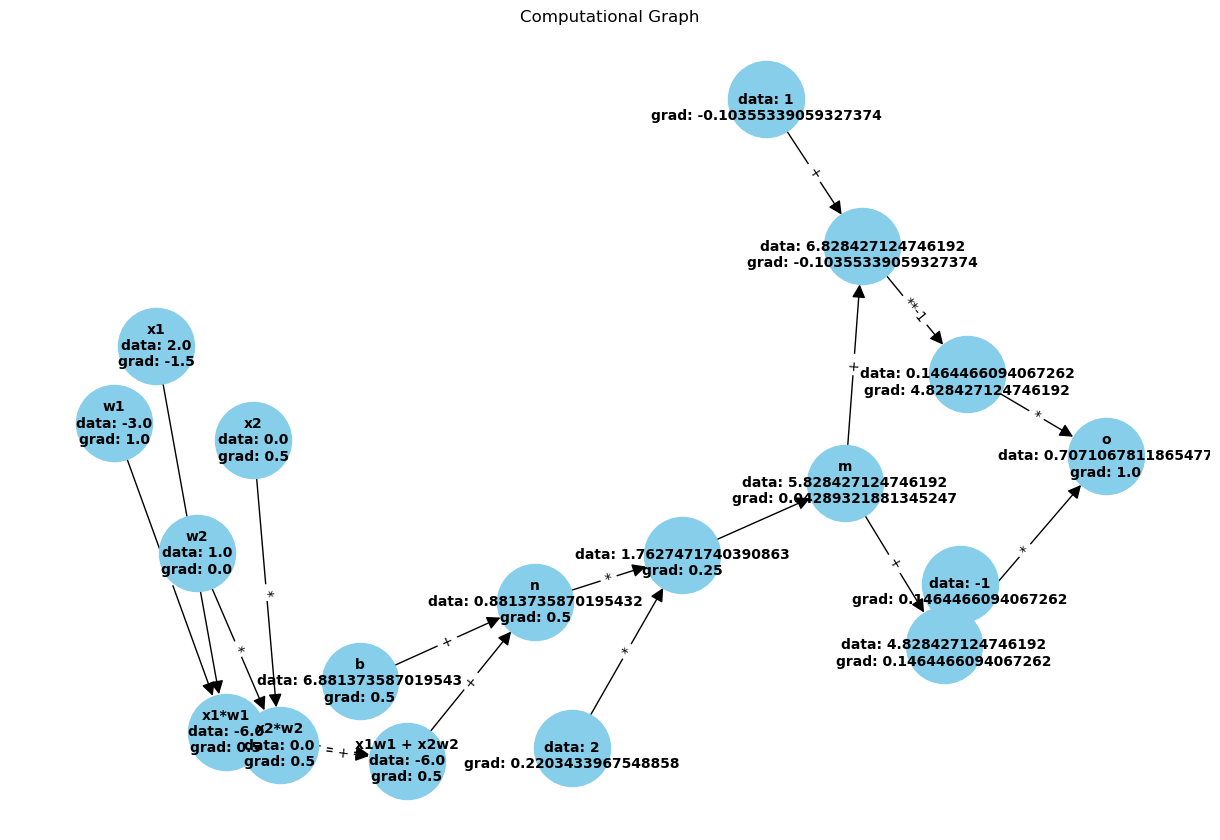

In [59]:
#inputs
x1 = Value(2.0,label = "x1")
x2 = Value(0.0,label = "x2")

#weights
w1 = Value(-3.0,label = "w1")
w2 = Value(1.0,label = "w2")

#bias
b  = Value(6.8813735870195432,label = "b") 

#dot product
x1w1     = x1 * w1;     x1w1.label = "x1*w1"
x2w2     = x2 * w2;     x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2" # sum of product of weights and input ()

# cell body 
n = x1w1x2w2 + b; n.label = "n"

# tanh = (e^2x -1) / (e^2x + 1 )
m = (2*n).exp();       m.label = "m"  
#output 
o = (m-1) / (m+1) ; o.label = "o" 
o.backward()
draw_networkx(o) 